## MNIST CNN

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

### Data

In [0]:
path = untar_data(URLs.MNIST)

In [7]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [22]:
il = ImageList.from_folder(path, convert_mode='L'); il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

In [11]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/training/7/58520.png')

In [17]:
type(defaults)

types.SimpleNamespace

In [0]:
defaults?

In [0]:
defaults.cmap='binary'

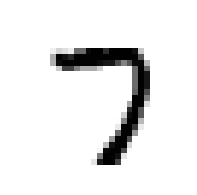

In [21]:
il[0].show()

In [0]:
sd = il.split_by_folder(train='training', valid='testing')

In [24]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
ll = sd.label_from_folder()

In [26]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x,y = ll.train[0]

7 torch.Size([1, 28, 28])


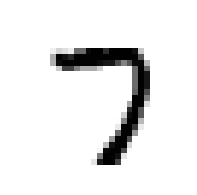

In [28]:
x.show()
print(y,x.shape)

In [94]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')],[]); tfms

([RandTransform(tfm=TfmPixel (pad), kwargs={'padding': 3, 'mode': 'zeros'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (crop), kwargs={'size': 28, 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [])

In [0]:
ll = ll.transform(tfms)

In [0]:
bs = 128

In [0]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

7


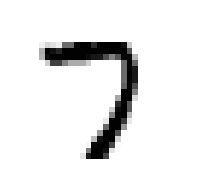

In [39]:
x,y = data.train_ds[0]
x.show()
print(y)

7


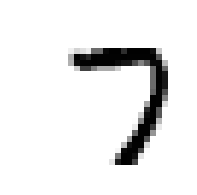

In [47]:
x,y = data.train_ds[0]
x.show()
print(y)

In [0]:
plot_multi?

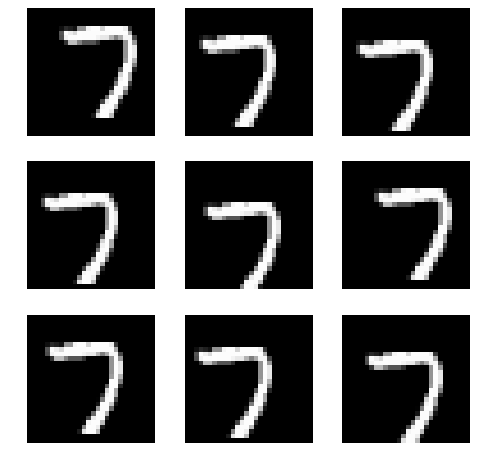

In [97]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [58]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

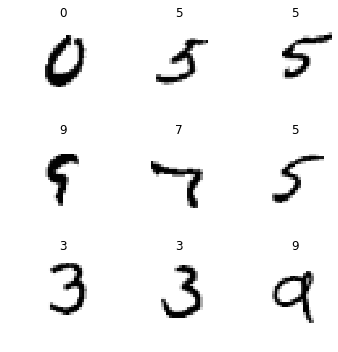

In [51]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [0]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [0]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [55]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

In [0]:
xb = xb.cuda()

In [61]:
model(xb).shape

torch.Size([128, 10])

In [62]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


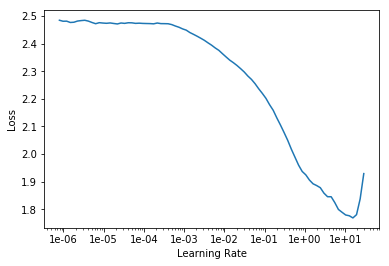

In [63]:
learn.recorder.plot()

In [64]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.219899,0.191535,0.940600,00:28
1,0.125723,0.082441,0.974500,00:29
2,0.083657,0.042723,0.986100,00:28


### Refactor

In [73]:
help(conv_layer)

Help on function conv_layer in module fastai.layers:

conv_layer(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, is_1d:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, use_activ:bool=True, leaky:float=None, transpose:bool=False, init:Callable=<function kaiming_normal_ at 0x7fd15d1fa840>, self_attention:bool=False)
    Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers.



In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2, padding=1)

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [72]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.225068,0.256816,0.918400,00:28
1,0.183538,0.149784,0.953900,00:28
2,0.155589,0.150879,0.949600,00:28
3,0.140011,0.100256,0.968700,00:28
4,0.124771,0.138474,0.955100,00:28
5,0.107217,0.075123,0.976700,00:28
6,0.088440,0.074003,0.975500,00:28
7,0.067695,0.041867,0.985900,00:28
8,0.050234,0.031262,0.990100,00:28
9,0.051838,0.029509,0.989500,00:28


### Resnet-ish

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [74]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [0]:
res_block??

In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


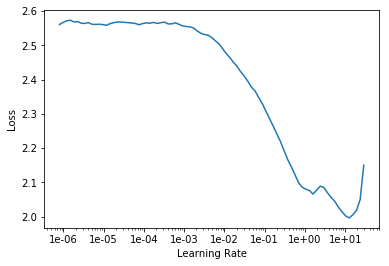

In [82]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(10, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.215668,0.265576,0.920200,00:30
1,0.136980,0.117001,0.964700,00:31
2,0.118595,0.091458,0.972200,00:30
3,0.078221,0.059262,0.982100,00:30
4,0.062305,0.049437,0.984900,00:31
5,0.053066,0.046830,0.983600,00:31
6,0.037989,0.031401,0.989700,00:31
7,0.031165,0.018420,0.994500,00:30
8,0.023644,0.017026,0.994600,00:30
9,0.019509,0.015123,0.995500,00:30


In [84]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________